# SEBAL Model with Meteorological data 
Sebal Model implementation with actual meteorological data and chosen Landsat 8 scenes from MesoHyd Project, Leipzig University. \
Data provided from Christopher Hutengs.
  

In [25]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from sklearn.linear_model import LinearRegression
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from rasterio.merge import merge
from rasterio.plot import show
import matplotlib
import matplotlib.pyplot as plt
import math
import spyndex
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import tarfile
import pathlib



import glob
import os
import os.path
import sys

In [28]:
# Path Conversion Tool
pathlib.PureWindowsPath(r"D:\Nicolas_D\Geodaten\Masterarbeit\DATA_MesoHyd_MA-SEBAL\Original\meteo_raster_daily\kelle_radiation\rad_raster_kelle_2015_7_4.tif").as_posix()


'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/meteo_raster_daily/kelle_radiation/rad_raster_kelle_2015_7_4.tif'

# Import data/Test
Get help/tutorial from https://www.earthdatascience.org/courses/use-data-open-source-python/

### Configure Data Access (Date, ...)

In [114]:

# Set date(s) of modelling/data retrieval
date = "2015-07-04"
date = pd.to_datetime(date, format = "%Y-%m-%d")
print("Date normal =", date)
print(type(date))

# Date in INTERMET-Raster Path Format
date_met = date.date()
date_met = date_met.strftime('%Y-%m-%d')
print("Date INTERMET =", date_met)
print(type(date_met))

# Date in WASIM-Raster Path Format
date_wasim = date.date()
date_wasim = date_wasim.strftime('%Y_%m_%d').replace("_0", "_")
print("Date WASIM =", date_wasim)
print(type(date_wasim))

# Date in Landsat Path Format
date_LS = date.date()
date_LS = date_LS.strftime('%Y%m%d')
print("Date Landsat =", date_LS)
print(type(date_LS))


Date normal = 2015-07-04 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Date INTERMET = 2015-07-04
<class 'str'>
Date WASIM = 2015_7_4
<class 'str'>
Date Landsat = 20150704
<class 'str'>


### Import Landsat 8 data - VIS/NIR

In [2]:
path = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/LANDSAT"
data = sorted(glob.glob(path + "/*.tar"))
data = data[1]


In [3]:
path2 = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/"
path3 = data[74:-4]
#path3 = print(path2, data[74:-4], sep = "")


In [4]:
path_combined = os.path.join(path2, path3)
path_combined
#os.mkdir(path_combined)

'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LC08_L2SP_196025_20150704_20200909_02_T1'

In [49]:
#tar = tarfile.open(data)
#tar.extractall(path = path_combined)
#tar.close()

In [5]:
data = sorted(glob.glob(path_combined + "/*.tif"))
data


['D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LC08_L2SP_196025_20150704_20200909_02_T1\\LC08_L2SP_196025_20150704_20200909_02_T1_QA_PIXEL.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LC08_L2SP_196025_20150704_20200909_02_T1\\LC08_L2SP_196025_20150704_20200909_02_T1_QA_RADSAT.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LC08_L2SP_196025_20150704_20200909_02_T1\\LC08_L2SP_196025_20150704_20200909_02_T1_SR_B1.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LC08_L2SP_196025_20150704_20200909_02_T1\\LC08_L2SP_196025_20150704_20200909_02_T1_SR_B2.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LC08_L2SP_196025_20150704_20200909_02_T1\\LC08_L2SP_196025_20150704_20200909_02_T1_SR_B3.TIF',
 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LC08_L2SP_196025_20150704_20200909_02_T1\\LC08_L2SP_1960

In [6]:
# open Metadatafile for extracting scale factors for VIIRS
meta_path = sorted(glob.glob(path_combined + "/*MTL.txt"))
meta = pd.read_csv(meta_path[0], sep = "=")
meta.iloc[:,0]

# Load and convert mutliplicative scale factor
scale_factor = meta[meta.iloc[:,0].str.contains("REFLECTANCE_MULT_BAND_1")].iloc[0,1]
scale_factor = float(scale_factor)
print("Scale factor =", scale_factor)

# Load and convert additive offset
scale_add = meta[meta.iloc[:,0].str.contains("REFLECTANCE_ADD_BAND_1")].iloc[0,1]
scale_add = float(scale_add)
print("Additive offset =", scale_add)

Scale factor = 2.75e-05
Additive offset = -0.2


In [7]:
# open Metadatafile for extracting scale factors for THERMAL
# Load and convert mutliplicative scale factor for Band 10 (Surface Temp in Kelvin)
scale_factor_thermal = meta[meta.iloc[:,0].str.contains("TEMPERATURE_MULT_BAND_ST_B10")].iloc[0,1]
scale_factor_thermal = float(scale_factor_thermal)
print("Scale factor Thermal =", scale_factor_thermal)

# Load and convert additive offset for Band 10 (Surface Temp in Kelvin)
scale_add_thermal = meta[meta.iloc[:,0].str.contains("TEMPERATURE_ADD_BAND_ST_B10")].iloc[0,1]
scale_add_thermal = float(scale_add_thermal)
print("Additive offset Thermal =", scale_add_thermal)


Scale factor Thermal = 0.00341802
Additive offset Thermal = 149.0


In [8]:
stack_dict = dict()

for i in range(2, 9):
    band_i = rxr.open_rasterio(data[i], masked = True).squeeze()
    band_corr = band_i*scale_factor+scale_add
    globals()[f"band_{i-1}"] = band_corr
    #print([f"band_{i-1}"])
    stack_dict[f"band_{i-1}"] = band_corr


In [9]:
# Add other needed bands to dictionary
# Band 10 Surface Temperature
stack_dict["band_10"] = rxr.open_rasterio(data[11], masked = True).squeeze()*scale_factor_thermal+scale_add_thermal

# Thermal Radiance TRAD
stack_dict["band_trad"] = rxr.open_rasterio(data[17], masked = True).squeeze()*0.001

# Emissivity estimated from ASTER_GED
stack_dict["emis"] = rxr.open_rasterio(data[14], masked = True).squeeze()*0.0001

# Level 2 Quality Pixel Band
stack_dict["QA_PIXEL"] = rxr.open_rasterio(data[0], masked = True).squeeze()

In [10]:
# Convert dictionaries xarrays into xr.Dataset
print(stack_dict.keys())
LS_stack = xr.Dataset(stack_dict)

dict_keys(['band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6', 'band_7', 'band_10', 'band_trad', 'emis', 'QA_PIXEL'])


In [11]:
# Open QA_PIXEL Band 
np.set_printoptions(suppress=True)
np.unique(LS_stack.QA_PIXEL, return_counts=True)


(array([    1., 21762., 21824., 21890., 21952., 22018., 22080., 22146.,
        22208., 22280., 23826., 23888., 24082., 24144., 54534., 54596.,
        54790., 54852., 55052., 56598., 56660., 56854., 56916.],
       dtype=float32),
 array([23811341,    38196, 33676164,      268,    55022,    22308,
          142708,       99,      678,    56639,    15430,   163476,
           16964,     6214,   149756,  2973093,   274098,   472231,
         1987473,    90227,   274284,   172785,    95007], dtype=int64))

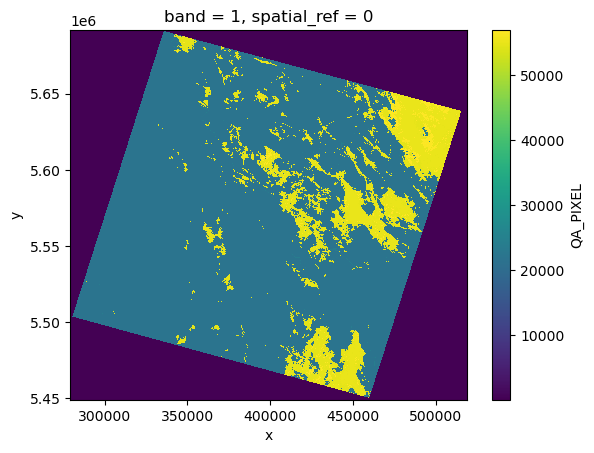

In [58]:
LS_stack.QA_PIXEL.plot()

### Import Landsat 8 data - Thermal

(array([    1092.,     5097.,    33440.,   613864.,  3096673., 14897173.,
        17944137.,  3994596.,    54693.,      197.]),
 array([244.18161011, 253.91407776, 263.64654541, 273.37902832,
        283.11148071, 292.84393311, 302.57641602, 312.30889893,
        322.04135132, 331.77380371, 341.50628662]),
 <BarContainer object of 10 artists>)

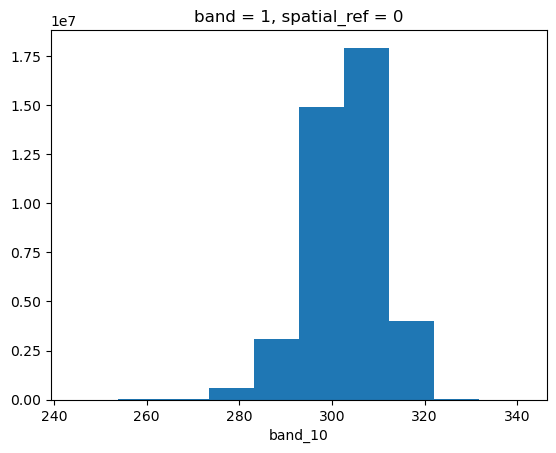

In [58]:
LS_stack.band_10.plot.hist()

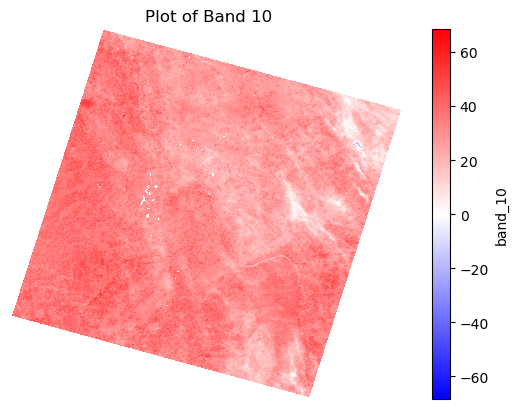

In [59]:
# T in Celsius
band_10_cels = LS_stack.band_10 - 273.15


# Colormap 
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["b", "w", "r"], N=256) 




# Plot the data
f, ax=plt.subplots()
band_10_cels.plot.imshow(ax=ax,
                  cmap=cmap)
ax.set_axis_off()
ax.set_title("Plot of Band 10")
plt.show()

In [60]:
print("Min:", np.nanmin(LS_stack.band_10.values))
print("Max:", np.nanmax(LS_stack.band_10.values))


Min: 244.18161
Max: 341.5063


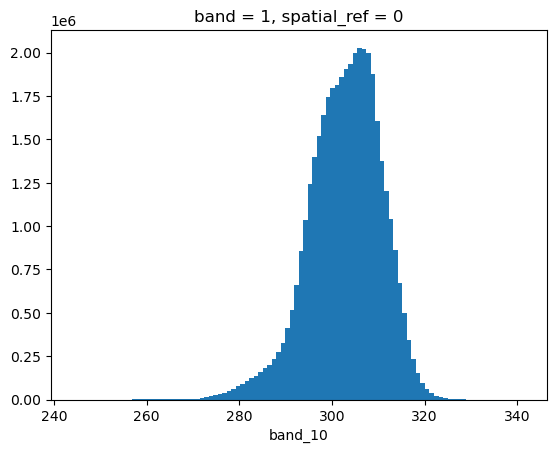

In [61]:
LS_stack.band_10.plot.hist(bins = 100)
plt.show()

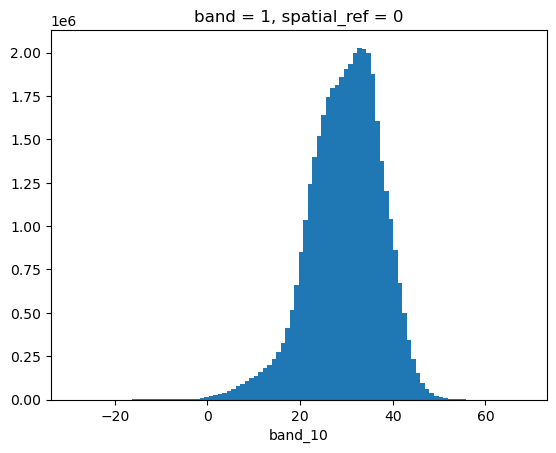

In [62]:
band_10_cels.plot.hist(bins = 100)
plt.show()

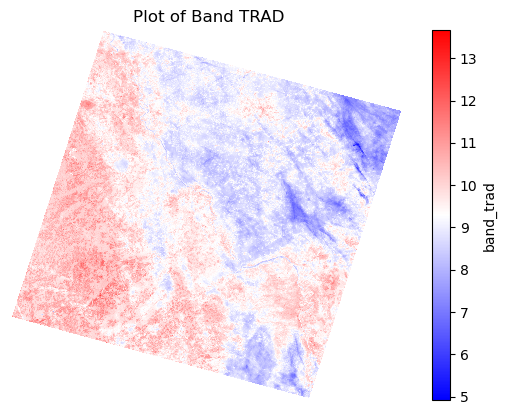

In [64]:
# Colormap 
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["b", "w", "r"], N=256) 

# Plot the data
f, ax=plt.subplots()
LS_stack.band_trad.plot.imshow(ax=ax,
                  cmap=cmap)
ax.set_axis_off()
ax.set_title("Plot of Band TRAD")
plt.show()

# Processing Steps

## 1. Preprocessing

### 1. Satellite Data

#### 1.1 Crop Satellite Data with Catchment Shapes


In [12]:
# Load Shapefile for Catchments
path_shapeA = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/study_area/altenbamberg_catchment.gpkg"
shape_alten = gpd.read_file(path_shapeA)

path_shapeK = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/study_area/kellenbach_catchment.gpkg"
shape_kellen = gpd.read_file(path_shapeK)

# Combine both Catchment Shapes
shape_catchments = pd.concat([shape_alten, shape_kellen])

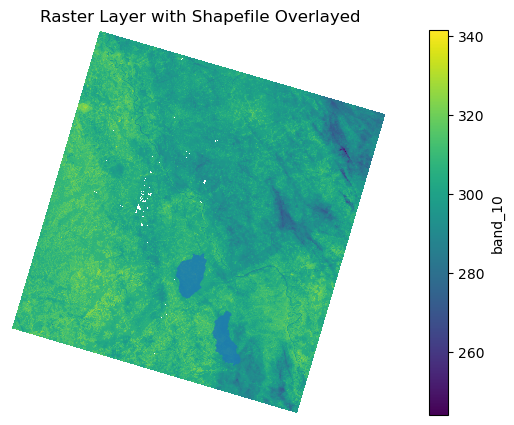

In [13]:
# Plot Catchments within Raster
f, ax = plt.subplots(figsize=(10, 5))
LS_stack.band_10.plot.imshow(ax=ax)

shape_catchments.plot(ax=ax,
                 alpha=.8)
ax.set(title="Raster Layer with Shapefile Overlayed")


ax.set_axis_off()
plt.show()

In [14]:
# Clip Landsat Raster with Shapefile
LS_stack_clip = LS_stack.rio.clip(shape_catchments.geometry, all_touched = True)

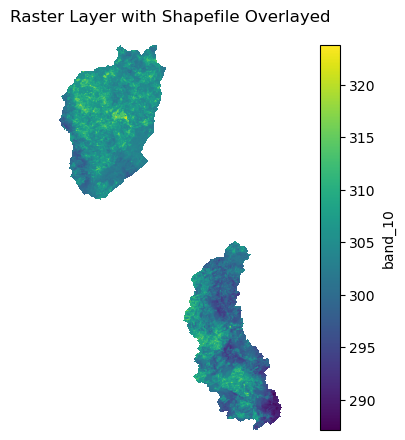

In [15]:
# Plot Catchments within Raster
f, ax = plt.subplots(figsize=(10, 5))
LS_stack_clip.band_10.plot.imshow(ax=ax)

shape_catchments.plot(ax=ax,
                alpha=0)
ax.set(title="Raster Layer with Shapefile Overlayed")


ax.set_axis_off()
plt.show()

In [16]:
# Safe cliped and processed raster stack to NetCDF
LS_stack_clip_float32 = LS_stack_clip.astype(np.float32)
LS_stack_clip_float32.to_netcdf("D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LS_Processed/LS08_20150704.nc")


In [2]:
# Load Cliped and processed raster stack (NetCDF)
LS_stack_clip = rxr.open_rasterio("D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/LANDSAT/LS_Processed/LS08_20150704.nc")

# Print Properties with reloaded "new" LS_stack_clip (from NetCDF file)
print(LS_stack_clip)
print(LS_stack_clip.rio.crs)



<xarray.Dataset>
Dimensions:      (band: 1, x: 1369, y: 2367)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 3.836e+05 3.837e+05 ... 4.246e+05 4.247e+05
  * y            (y) float64 5.551e+06 5.551e+06 5.551e+06 ... 5.48e+06 5.48e+06
    spatial_ref  int32 0
Data variables:
    band_1       (band, y, x) float32 ...
    emis         (band, y, x) float32 ...
    QA_PIXEL     (band, y, x) float32 ...
    band_2       (band, y, x) float32 ...
    band_3       (band, y, x) float32 ...
    band_4       (band, y, x) float32 ...
    band_5       (band, y, x) float32 ...
    band_6       (band, y, x) float32 ...
    band_7       (band, y, x) float32 ...
    band_10      (band, y, x) float32 ...
    band_trad    (band, y, x) float32 ...
None


In [3]:
# Fix issues if lost CRS and lat/long dimensions of loaded LS_stack_clip from NetCDF
LS_stack_clip = LS_stack_clip.rename({"x": "long", "y": "lat"})
LS_stack_clip = LS_stack_clip.sortby(["band", "lat", "long"])
LS_stack_clip.rio.write_crs("epsg:32632", inplace=True)
LS_stack_clip = LS_stack_clip.squeeze()

In [15]:
LS_stack_clip

<xarray.Dataset>
Dimensions:      (long: 1369, lat: 2367)
Coordinates:
    band         int32 1
  * long         (long) float64 3.836e+05 3.837e+05 ... 4.246e+05 4.247e+05
  * lat          (lat) float64 5.48e+06 5.48e+06 ... 5.551e+06 5.551e+06
    spatial_ref  int32 0
Data variables:
    band_1       (lat, long) float32 ...
    emis         (lat, long) float32 ...
    QA_PIXEL     (lat, long) float32 ...
    band_2       (lat, long) float32 ...
    band_3       (lat, long) float32 ...
    band_4       (lat, long) float32 ...
    band_5       (lat, long) float32 ...
    band_6       (lat, long) float32 ...
    band_7       (lat, long) float32 ...
    band_10      (lat, long) float32 ...
    band_trad    (lat, long) float32 ...

In [16]:
# Open QA_PIXEL Band 
np.set_printoptions(suppress=True)
u, count = np.unique(LS_stack_clip.QA_PIXEL, return_counts=True)
count_sort_ind = np.argsort(-count)
print(u[count_sort_ind])
print(count[count_sort_ind])

[   nan 21824. 54596. 54852. 23888. 56660. 54534. 56916. 55052. 56598.
 56854. 54790. 22080. 22280. 21762. 21952. 22018.]
[2481029  714245   39513    3538     379     327     271     246     214
     192     151     149     129      20      17       2       1]


#### 1.2 Apply Cloud Mask (Quality Assessment Band)
Steps by https://pages.cms.hu-berlin.de/EOL/gcg_eo/02_data_quality.html

In [4]:
# Mask any values other than "Clear with low confidence on Clouds"
LS_stack = LS_stack_clip.where(LS_stack_clip.QA_PIXEL.values == 21824)

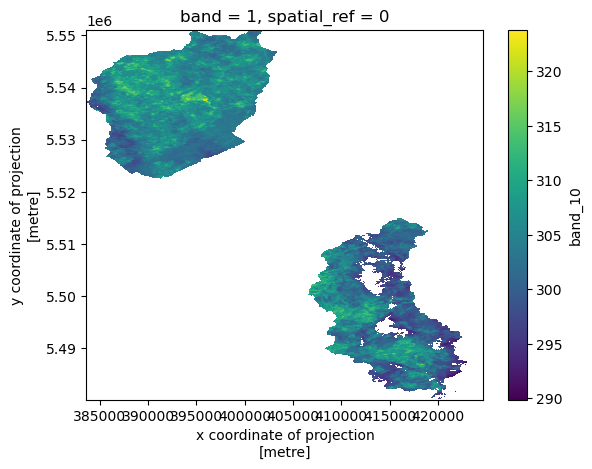

In [5]:
LS_stack.band_10.plot()

In [19]:
LS_stack

<xarray.Dataset>
Dimensions:      (lat: 2367, long: 1369)
Coordinates:
    band         int32 1
  * long         (long) float64 3.836e+05 3.837e+05 ... 4.246e+05 4.247e+05
  * lat          (lat) float64 5.48e+06 5.48e+06 ... 5.551e+06 5.551e+06
    spatial_ref  int32 0
Data variables:
    band_1       (lat, long) float32 nan nan nan nan nan ... nan nan nan nan nan
    emis         (lat, long) float32 nan nan nan nan nan ... nan nan nan nan nan
    QA_PIXEL     (lat, long) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_2       (lat, long) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_3       (lat, long) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_4       (lat, long) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_5       (lat, long) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_6       (lat, long) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_7       (lat, long) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_10      (lat, long) float32 nan nan nan nan nan ... nan nan nan nan nan
    band_trad    (lat, long) float32 nan nan nan nan nan ... nan nan nan nan nan

### 2. Land Use Map

In [6]:
# Open Corine Land Use Maps for both catchments
path_LUA = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/study_area/altenuse-ch.tif"
LU_alten = rxr.open_rasterio(path_LUA).squeeze()


path_LUK = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/study_area/kelleuse-ch.tif"
LU_kellen = rxr.open_rasterio(path_LUK).squeeze()



In [7]:
LU_alten = rio.open(path_LUA)
LU_kellen = rio.open(path_LUK)


In [8]:
mosaic, out_trans = rio.merge.merge([LU_alten, LU_kellen])

### 3. Meteorolocial Data

#### 3.1 Wind
Load and process wind data (Station data, one point per catchment, from WASIM Meteo Data)


In [12]:
# Read Wind tables from meteo data
path_meteo: str = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/meteo_original/"
path_wind_alten: str = path_meteo + "Wind2010_alten.txt"
path_wind_kellen: str = path_meteo + "Wind2010_kellen.txt"
wind_alten = pd.read_csv(path_wind_alten, delimiter = "\t", header = [3])
wind_kellen = pd.read_csv(path_wind_kellen, delimiter = "\t", header = [3])

# Change Hour to Start time of day at 00:00 midnight 
wind_alten.iloc[:,3] = wind_alten.iloc[:,3]-1 
wind_kellen.iloc[:,3] = wind_kellen.iloc[:,3]-1 

# Create DateTimeIndex based on Date columns
alten_wind_date_index = pd.to_datetime(wind_alten.iloc[:,0:4].astype(str).agg("-".join, axis = 1), format = "%Y-%m-%d-%H")
kellen_wind_date_index = pd.to_datetime(wind_kellen.iloc[:,0:4].astype(str).agg("-".join, axis = 1), format = "%Y-%m-%d-%H")

# Built final wind dataframe
wind_alten_df = wind_alten.iloc[:,4].to_frame()
wind_kellen_df = wind_kellen.iloc[:,4].to_frame()

# Add Date Index
wind_alten_df = wind_alten_df.set_index([alten_wind_date_index])
wind_kellen_df = wind_kellen_df.set_index([kellen_wind_date_index])

# Outer Join for both data frames Altenbamberg and Kellenbach
wind_df = pd.concat([wind_alten_df, wind_kellen_df], axis = 1)
wind_df.columns = ["wind_altenbamberg", "wind_kellenbach"]
wind_df.index.name = "date"
wind_df

# Export to csv
# wind_df.to_csv("D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Processed/meteo_processed/wind_velocity.csv")



wind_altenbamberg  wind_kellenbach
date                                                   
2009-01-01 00:00:00                NaN              0.0
2009-01-01 01:00:00                NaN              0.0
2009-01-01 02:00:00                NaN              0.0
2009-01-01 03:00:00                NaN              0.0
2009-01-01 04:00:00                NaN              0.4
...                                ...              ...
2020-12-31 19:00:00                0.7              1.1
2020-12-31 20:00:00                0.7              1.3
2020-12-31 21:00:00                0.5              1.4
2020-12-31 22:00:00                0.2              0.9
2020-12-31 23:00:00                0.3              0.5

[105192 rows x 2 columns]

## 2. Surface Radiation Balance

### 2.1 NDVI, SAVI, LAI

In [13]:
# NDVI
# NDVI = (band_5 - band_4) / (band_5 + band_4)

NDVI = spyndex.computeIndex(
    index = "NDVI",
    params = {
        "N": LS_stack.band_5,
        "R": LS_stack.band_4
    }
)

In [14]:
# SAVI
# SAVI = (1+L_savi)*(band_5 - band_4) / (L_savi+band_5 + band_4)
L_savi = 0.5       # Value should be adjusted according to Soil Moisture (0.1 and 0.5 are suggested)

SAVI = spyndex.computeIndex(
    index = "SAVI",
    params = {
        "L": L_savi,
        "N": LS_stack.band_5,
        "R": LS_stack.band_4
    }
)

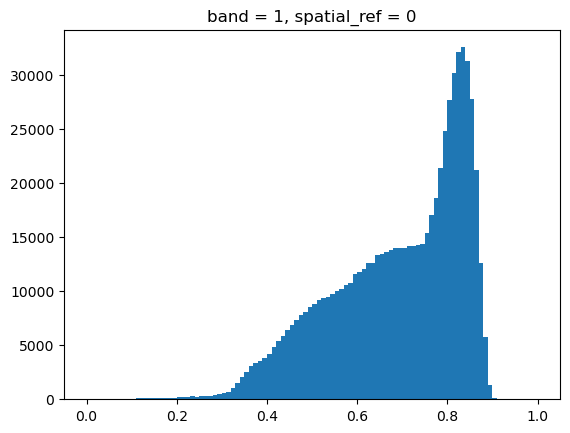

In [15]:
NDVI.plot.hist(range=[0.0, 1.0], bins = 100)
plt.show()

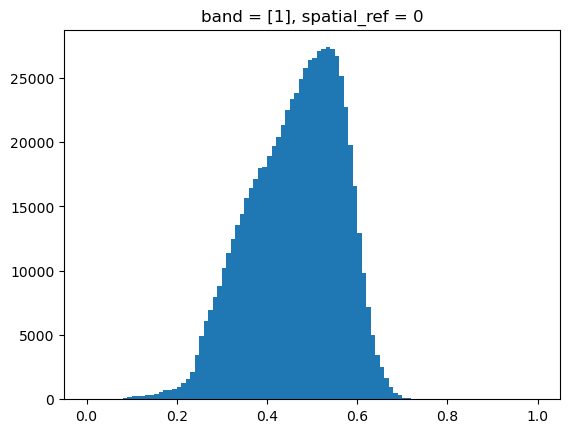

In [45]:
SAVI.plot.hist(range=[0.0, 1.0], bins = 100)
plt.show()

In [16]:
# LAI
LAI = -(np.log((0.69-SAVI)/0.59)/0.91) 


c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


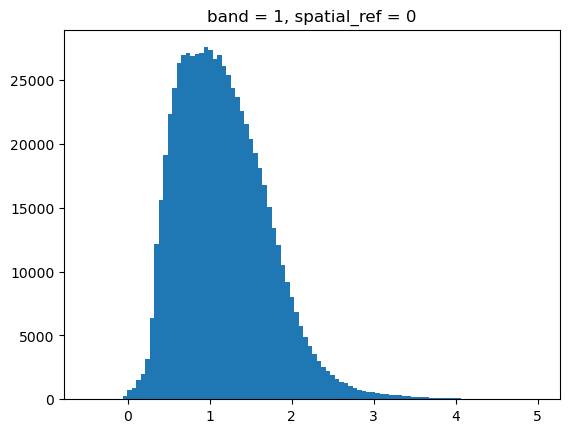

In [17]:
LAI.plot.hist(range=[-0.5, 5.0], bins = 100)
plt.show()

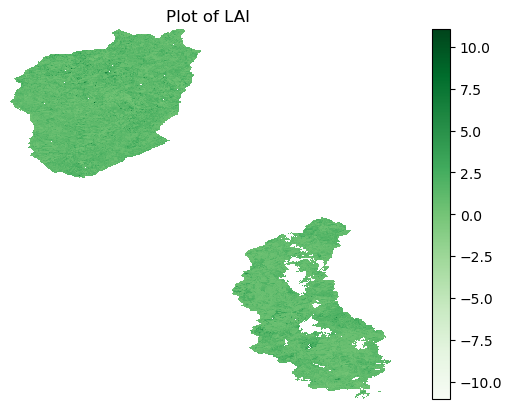

In [18]:
# Plot the data
f, ax=plt.subplots()
LAI.plot.imshow(ax=ax,
                  cmap = "Greens")
ax.set_axis_off()
ax.set_title("Plot of LAI")
plt.show()

### 2.2 Albedo
First Test Calculation from LS8 Reflectances based on https://yceo.yale.edu/how-convert-landsat-dns-albedo
Caution: intended for TOA, but here used with BOA-Reflectances

In [19]:
B1 = LS_stack.band_2     # Blue
B2 = LS_stack.band_4     # Red
B3 = LS_stack.band_5     # NIR 1 (0.76-0.9)
B4 = LS_stack.band_6     # NIR 2 (1.55-1.75)
B5 = LS_stack.band_7     # MIR (2.08-2.35)


albedo = ((0.356*B1) + (0.130*B2) + (0.373*B3) + (0.085*B4) + (0.072*B5) -0.018) / 1.016

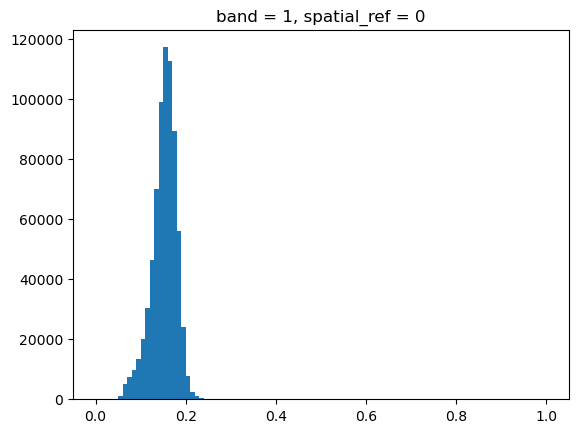

In [20]:
albedo.plot.hist(range=[0.0, 1.0], bins = 100)
plt.show()

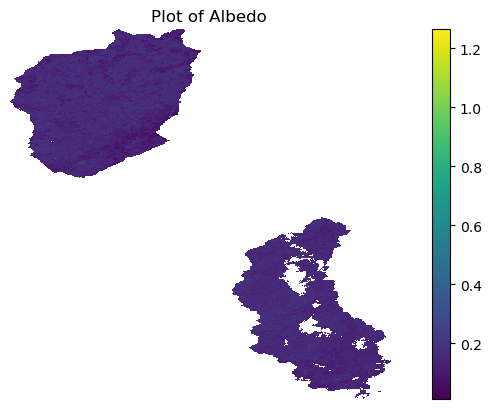

In [22]:
# Plot the data
f, ax=plt.subplots()
albedo.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("Plot of Albedo")
plt.show()

### 2.3 Rs - Incoming Shortwave Radiation
#### 2.3.1 Easy Formula Approach from SEBAL_manual

In [96]:
# Rs Incoming - Easy Formula Approach from SEBAL_manual
# RS_incoming in W/m²

Gsc = 1367                  # Solar Constant in W/m²

# Solar Incidence Angle 
sun_elev = 39.24065277      # Sun elevation angle in degree, from Metadata_file
solar_inc = 90-sun_elev     # Solar Incidence Angle

# dr
DOY = 263                   # DOY of 19. September 2020
dr = 1+0.033*math.cos(DOY*(2*math.pi/365))  # relative sun-earth-distance dr 

# Atmospheric transmissivity
z = 104     # elevation above sea level (m) for Station (here: Bad Kreuznach elevation)     
tau_sw = 0.75+2*10**-5*z

# RS_incoming in W/m² (should be between 200 and 1000)
RS_in = Gsc * math.cos(solar_inc) * dr * tau_sw
RS_in

899.7472321021972

#### 2.3.2 Use of Spatial Radiation Data from INTERMET and WASIM-Model

In [151]:
# Create Path for recursive file search based on defined date
path_intermet = "D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/meteo_raster_daily/"
pattern = f"*rad*{date_wasim}*.tif"
#paths_intermet_rad = 
paths_intermet_rad = sorted(glob.glob(os.path.join(path_intermet_rad, "**", pattern), recursive=True))
print(paths_intermet_rad)

# Open INTERMET Radiation Rasters and set Lat/Long/CRS
# Catchment Altenbamberg
intermet_rad_alten = rxr.open_rasterio(paths_intermet_rad[0]).squeeze()
intermet_rad_alten = intermet_rad_alten.rename({"x": "long", "y": "lat"})
intermet_rad_alten = intermet_rad_alten.sortby(["lat", "long"])
intermet_rad_alten.rio.write_crs("epsg:32632", inplace=True)

# Catchment Kellenbach
intermet_rad_kellen = rxr.open_rasterio(paths_intermet_rad[1]).squeeze()
intermet_rad_kellen = intermet_rad_kellen.rename({"x": "long", "y": "lat"})
intermet_rad_kellen = intermet_rad_kellen.sortby(["lat", "long"])
intermet_rad_kellen.rio.write_crs("epsg:32632", inplace=True)



['D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/meteo_raster_daily\\alten_radiation\\rad_raster_alten_2015_7_4.tif', 'D:/Nicolas_D/Geodaten/Masterarbeit/DATA_MesoHyd_MA-SEBAL/Original/meteo_raster_daily\\kelle_radiation\\rad_raster_kelle_2015_7_4.tif']


<xarray.DataArray (lat: 30, long: 20)>
[600 values with dtype=float32]
Coordinates:
    band         int32 1
  * long         (long) float64 2.599e+06 2.6e+06 ... 2.617e+06 2.618e+06
  * lat          (lat) float64 5.524e+06 5.525e+06 ... 5.552e+06 5.553e+06
    spatial_ref  int32 0
Attributes:
    STATISTICS_MAXIMUM:  305.70834350586
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  288.95834350586
    STATISTICS_STDDEV:   -9999
    _FillValue:          -3.4e+38
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           layer

TypeError: 'numpy.ndarray' object is not callable

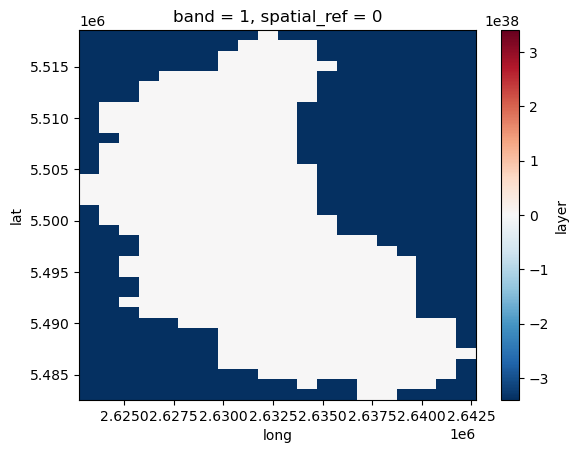

In [159]:
# Preprocessing Raster to match other Raster/Landsat data

# Plot original raster to compare
intermet_rad_alten_copy = intermet_rad_alten
intermet_rad_alten_copy.plot()



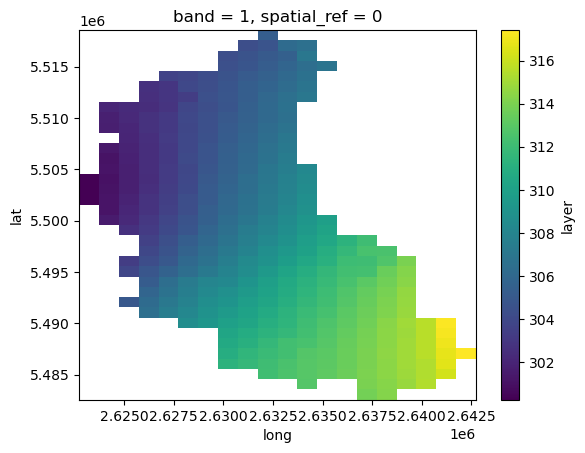

In [170]:
# Preprocessing
intermet_rad_alten.where(intermet_rad_alten > 0).plot()

### 2.4 RL - Outgoing Longwave Radiation

Surface Emissivity (C, 2.), Thermal Radiance (C, 3.), Surface Temperature (C, 4.) are not needed at the moment because we already got Surface Temperature from Landsat Level 2


In [33]:
print("Max LAI:", np.nanmax(LAI.values))

Max LAI: 16.177588


In [34]:
emis_null = xr.where((LAI < 3) | LAI.isnull(), 0.95 + 0.01*LAI, 0.98)
emis_null

<xarray.DataArray (y: 8081, x: 7981)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int32 1
  * x            (x) float64 2.787e+05 2.787e+05 ... 5.181e+05 5.181e+05
  * y            (y) float64 5.692e+06 5.692e+06 ... 5.449e+06 5.449e+06
    spatial_ref  int32 0

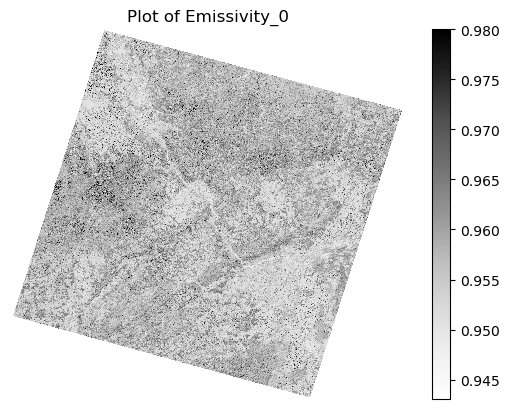

In [35]:
# Plot the data
f, ax=plt.subplots()
emis_null.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of Emissivity_0")
plt.show()

In [36]:
# Outgoing Longwave Radiation
# typical Range: 200-700 W/m²
Ts = band_10    # Surface Temperature in Kelvin 
sigma = 5.67*10**-8     # Boltzmann constant in W/m²/K**4

RL_out = emis_null * sigma * Ts**4
RL_out

<xarray.DataArray (y: 8081, x: 7981)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int32 1
  * x            (x) float64 2.787e+05 2.787e+05 ... 5.181e+05 5.181e+05
  * y            (y) float64 5.692e+06 5.692e+06 ... 5.449e+06 5.449e+06
    spatial_ref  int32 0

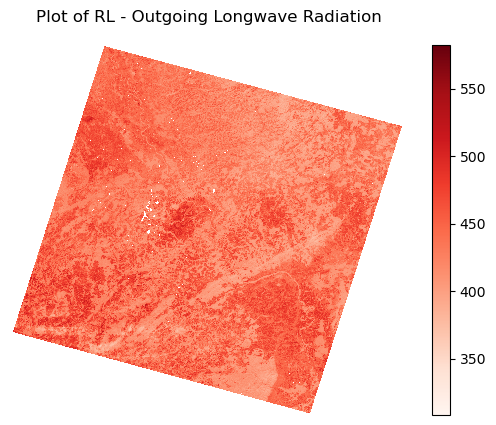

In [37]:
# Plot the data
f, ax=plt.subplots()
RL_out.plot.imshow(ax=ax,
                  cmap = "Reds")
ax.set_axis_off()
ax.set_title("Plot of RL - Outgoing Longwave Radiation")
plt.show()

### 2.5 RL - Incoming Longwave Radiation

In [38]:
# Incoming Longwave Radiation
# typical Range: 200-500 W/m²
Tcold = 290             # Assuming Tcold is 290 Kelvin, based on band_10 Histogram
Ta = Tcold              # Near Surface Air Temperature in Kelvin from T_cold (T Cold Pixel)
sigma = 5.67*10**-8     # Boltzmann constant in W/m²/K**4
emis_atmo = 0.85 * (-np.log(tau_sw))**0.09  # Empirical Formula for Atmospheric Emissivity

RL_in = emis_atmo * sigma * Ta**4
RL_in

304.45143274489214

### 2.6 Solving vor Rn

In [39]:
# Solving for Net Surface Radiation Flux Rn
# typical Range: 100-700 W/m²
Rn = (1-albedo)*RS_in + RL_in - RL_out - (1-emis_null)*RL_in  # After SEBAL Manual

# Other Formula based on Allen 2007 / M.L. Fischer Script
# Rn_allen = RS_in - (albedo*RS_in) + RL_in - RL_out - (1-emis_null)*RL_in

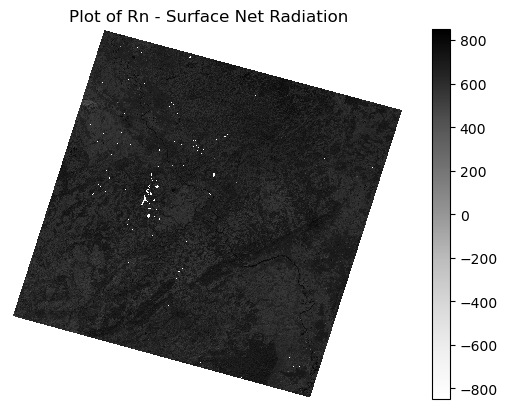

In [40]:
# Plot the data
f, ax=plt.subplots()
Rn.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of Rn - Surface Net Radiation")
plt.show()

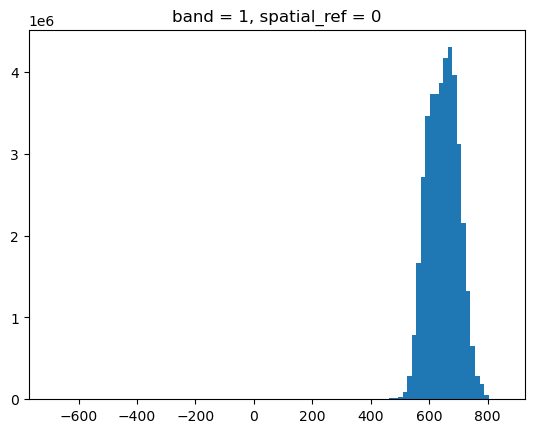

In [41]:
Rn.plot.hist(bins = 100)
plt.show()

## 3. Surface Energy Balance

### 3.1 G - Soil Heat Flux

In [42]:
# Soil Heat Flux
G_Rn_ratio = ((Ts-273.16)/albedo * ((0.0038*albedo)+(0.0075*(albedo**2)))*(1-0.98*(NDVI**4)))
G = G_Rn_ratio*Rn


print("Min:", np.nanmin(G_Rn_ratio.values))
print("Max:", np.nanmax(G_Rn_ratio.values))



Min: -3809089300.0
Max: 0.5335194


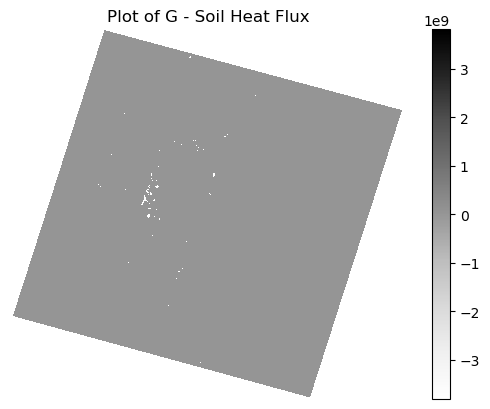

In [43]:
# Plot the data
f, ax=plt.subplots()
G_Rn_ratio.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of G - Soil Heat Flux")
plt.show()

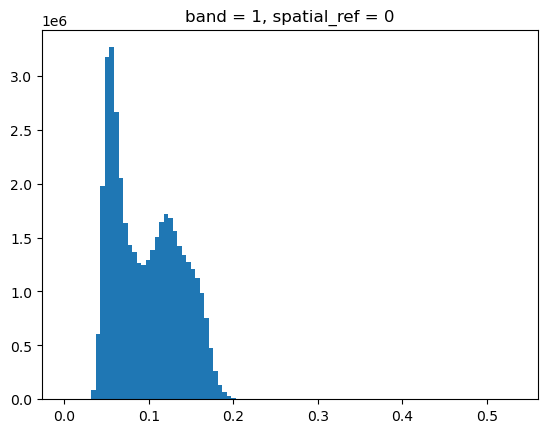

In [44]:
G_Rn_ratio_filt = G_Rn_ratio.where(G_Rn_ratio>0)
G_filt = G.where(G_Rn_ratio>0)

G_Rn_ratio_filt.plot.hist(bins = 100)
plt.show()

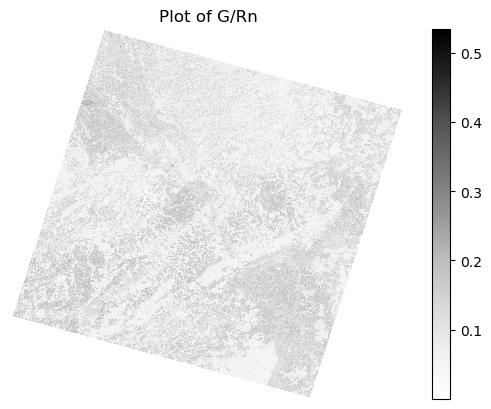

In [45]:
# Plot the data
f, ax=plt.subplots()
G_Rn_ratio_filt.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of G/Rn")
plt.show()

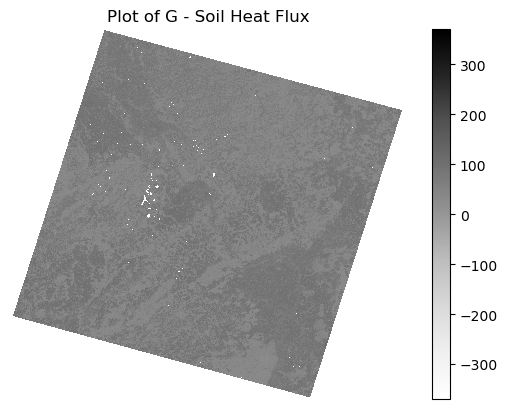

In [46]:
# Plot the data
f, ax=plt.subplots()
G_filt.plot.imshow(ax=ax,
                  cmap = "Greys")
ax.set_axis_off()
ax.set_title("Plot of G - Soil Heat Flux")
plt.show()

### 3.2 H - Sensible Heat Flux

#### 3.2.1 Aerodynamic Resistance r_ah

In [47]:
# r_ah for neutral stability
# Final Formula: r_ah = (np.log(z2/z1)) / (u_asterix * k)
# Values are just assumed for testing, later taken from actual weather data according to the station
k = 0.41    # Karmans constant

ux = 20     # Wind speed at height zx (m/s)
zx = 2      # Height x with measured Wind speed ux
h_veg = 0.5      # Vegetation Heigh in m at weather station
zom_station = 0.12*h_veg   # momentum roughness length (m) at the weather station, SEBAL Manual suggests 0.12*height_vegetation


In [48]:
# 1. Friction veolocity u_asterix --> logaritmic wind profile
u_asterix = (k*ux) / (np.log(zx / zom_station))
u_asterix

2.338475576367114

In [49]:
# 2. Wind speed at 200m above ground u200
u200 = u_asterix * ((np.log(200/zom_station)) / k)
u200

46.26604391450525

In [50]:
# 3. Friction Velocity u_asterix_px for each Pixel 
#zom_px =  exp()          # Momentum roughness length (m) for each Pixel of the Image

#u_asterix_px = (k*u200) / (np.log(200 / zom_px))

# Assumed, simple variante (only for agriculture viable)
zom_px = 0.018 * LAI
u_asterix_px = (k*u200) / (np.log(200/zom_px))

c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [51]:
# 4. Initial Aerodynamic resistance r_ah
z1 = 0.1     # Height 1 for Wind Measurement (m), from SEBAL Manual
z2 = 2       # Height 2 for Wind Measurement (m), from SEBAL Manual

r_ah = (np.log(z2/z1)) / (u_asterix_px * k)

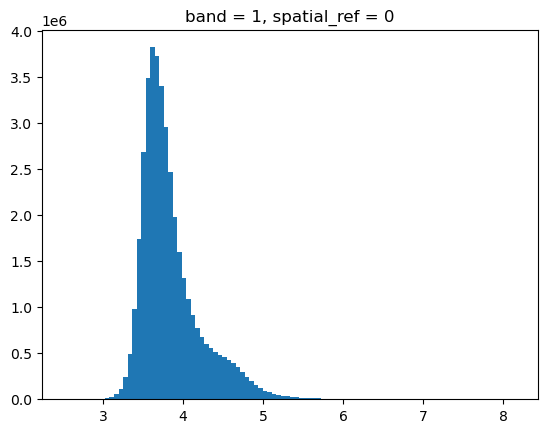

In [52]:
r_ah.plot.hist(bins = 100)
plt.show()

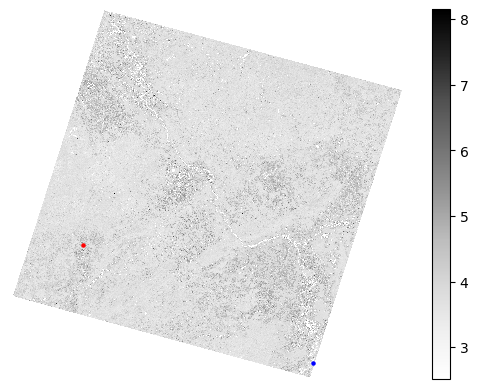

In [53]:
# Plot the data
f, ax=plt.subplots()
r_ah.plot.imshow(ax=ax,
                  cmap = "Greys")
plt.scatter([3.227e+05],[5.537e+06], color='red', s=5)
plt.scatter([4.616e+05],[5.46e+06], color='blue', s=5)
ax.set_axis_off()
ax.set_title("")
plt.show()

In [54]:
# 5. Compute H from dT (near surface temperature difference)
# Compute H and dT for hot and cold anchor pixels

# COLD PIXEL
# Test with assumption that Hcold = 0 over water bodie with zero sensible heat flux

H_cold = 0
dT_cold = 0


# HOT PIXEL
H_hot = Rn - G
# Get r_ah for Hot Pixel after filtering r_ah non NAN
Ts_nonan = Ts.where(((np.isnan(r_ah) == False)), drop = True)
r_ah_hot = r_ah.where(Ts==Ts_nonan.max(), drop = True)
roh_hot = 1.293     # Air density (kg/m³), Assumed value, should be calculated based on height and T_air
cp = 1004           # Air specific heat (J/kg/K)
dT_hot = H_hot * r_ah_hot / (roh_hot*cp)

In [55]:
# 5.1 Linear Regression on T against dT --> get coeffiients b and a
Ts_cold = Ts_nonan.min()
Ts_hot = Ts_nonan.max()

# Create Arrays for Linear Regression
Ts_linreg = np.array([Ts_cold.item(), Ts_hot.item()]).reshape((-1, 1))
dT_linreg = np.array([dT_cold, dT_hot.item()])

# Build Linear Model
dT_model = LinearRegression().fit(Ts_linreg, dT_linreg)

# Extract Coefficients after dT = b + a*Ts
coeff_b = dT_model.intercept_
coeff_a = dT_model.coef_ 

In [56]:
# 5.2 Calculate dT for each Pixel based on Ts and and Linear Model dT_model
dT_pix = coeff_b + coeff_a*Ts_nonan

In [57]:
# 6. Calculate Air Temperature Ta and Air density based on Ts and dT 
Ta_pix = Ts_nonan - dT_pix

# Calculate Air density roh 
pressure = 101325  # Air Pressure in Pascal, assumed Value from Wikipedia
Rs_constant = 287.058   # Specific Gas constant in J/Kg*K

roh_pix = pressure / (Rs_constant * Ta_pix)

In [58]:
# 7. Calculate Sensible Heat Flux H with initial r_ah under neutral atmospheric conditions
H = (roh_pix * cp * dT_pix) / r_ah



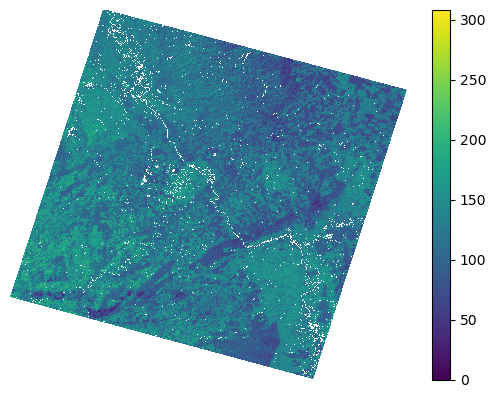

In [59]:
# Plot the data
f, ax=plt.subplots()
H.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

In [60]:
# 8. Stability correction/iteration
g = 9.81    # Gravitational constant, m/s²

# Monin-Obukhov Length L_mo
L_mo = -(roh_pix * cp * u_asterix_px**3 * Ts) / (k * g * H)




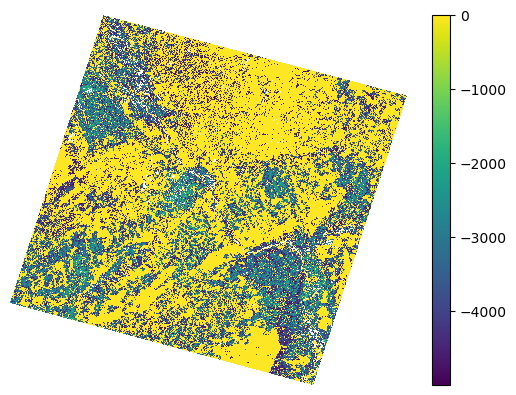

In [61]:
# Plot the data
data = L_mo > -5000
data = L_mo * data

f, ax=plt.subplots()
data.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

In [62]:
L_mo_filt = L_mo.where(((L_mo < 1000) & (L_mo > -50000)), drop = True)
L_mo_filt

<xarray.DataArray (y: 8025, x: 7823)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 2.804e+05 2.805e+05 ... 5.151e+05 5.151e+05
  * y            (y) float64 5.691e+06 5.691e+06 5.691e+06 ... 5.45e+06 5.45e+06
    band         int32 1
    spatial_ref  int32 0

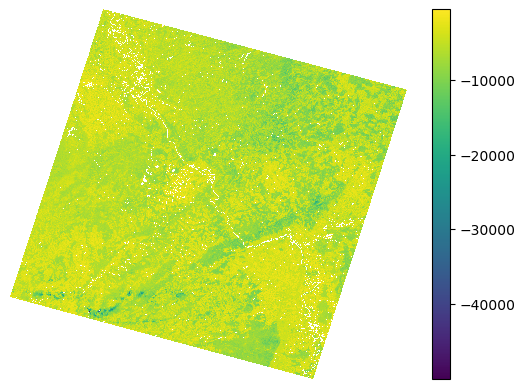

In [63]:
f, ax=plt.subplots()
L_mo_filt.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

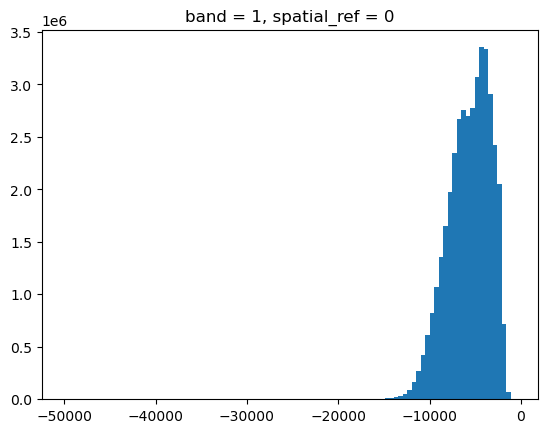

In [64]:
L_mo_filt.plot.hist(bins = 100)
plt.show()

In [65]:
# Coefficients for correction functions below
L_mo = L_mo_filt

x_200 = (1-(16*200/L_mo))**0.25
x_2 = (1-(16*2/L_mo))**0.25
x_01 = (1-(16*0.1/L_mo))**0.25

In [66]:
# Corections for momentum psi_m and heat transport psi_h 
# 1. Correction for psi_m_200

# if L_mo < 0
psi_m_200_neg = (2*np.log((1+x_200)/ 2)) + np.log((1+x_200**2)/2) - 2*np.arctan(x_200) + 0.5*math.pi
# if L_mo > 0
psi_m_200_pos = -5*(2/L_mo)



psi_m_200 = L_mo    
psi_m_200 = psi_m_200.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_m_200_neg) 
psi_m_200 = psi_m_200.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
psi_m_200 = psi_m_200.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_m_200_pos) 

psi_m_200

<xarray.DataArray (y: 8025, x: 7823)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 2.804e+05 2.805e+05 ... 5.151e+05 5.151e+05
  * y            (y) float64 5.691e+06 5.691e+06 5.691e+06 ... 5.45e+06 5.45e+06
    band         int32 1
    spatial_ref  int32 0

In [67]:
x_val = 5200
y_val = 5200

print("L_mo =", L_mo[x_val, y_val])
print("psi_m_200_neg =", psi_m_200_neg[x_val, y_val])
print("psi_m_200_pos =", psi_m_200_pos[x_val, y_val])
print("psi_m_200 =", psi_m_200[x_val, y_val])

      

L_mo = <xarray.DataArray ()>
array(-2389.50684395)
Coordinates:
    x            float64 4.364e+05
    y            float64 5.535e+06
    band         int32 1
    spatial_ref  int32 0
psi_m_200_neg = <xarray.DataArray ()>
array(0.24769406)
Coordinates:
    x            float64 4.364e+05
    y            float64 5.535e+06
    band         int32 1
    spatial_ref  int32 0
psi_m_200_pos = <xarray.DataArray ()>
array(0.00418496)
Coordinates:
    x            float64 4.364e+05
    y            float64 5.535e+06
    band         int32 1
    spatial_ref  int32 0
psi_m_200 = <xarray.DataArray ()>
array(0.24769406)
Coordinates:
    x            float64 4.364e+05
    y            float64 5.535e+06
    band         int32 1
    spatial_ref  int32 0


In [68]:
# Corections for momentum psi_m and heat transport psi_h 
# 2. Correction for psi_h_2

# if L_mo < 0
psi_h_2_neg = 2*np.log((1+x_2**2)/2)
# if L_mo > 0
psi_h_2_pos = -5*(2/L_mo)



psi_h_2 = L_mo    
psi_h_2 = psi_h_2.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_2_neg) 
psi_h_2 = psi_h_2.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
psi_h_2 = psi_h_2.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_2_pos) 

psi_h_2

<xarray.DataArray (y: 8025, x: 7823)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 2.804e+05 2.805e+05 ... 5.151e+05 5.151e+05
  * y            (y) float64 5.691e+06 5.691e+06 5.691e+06 ... 5.45e+06 5.45e+06
    band         int32 1
    spatial_ref  int32 0

In [69]:
# Corections for momentum psi_m and heat transport psi_h 
# 3. Correction for psi_h_01

# if L_mo < 0
psi_h_01_neg = 2*np.log((1+x_01**2)/2)
# if L_mo > 0
psi_h_01_pos = -5*(0.1/L_mo)



psi_h_01 = L_mo    
psi_h_01 = psi_h_01.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_01_neg) 
psi_h_01 = psi_h_01.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
psi_h_01 = psi_h_01.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_01_pos) 

psi_h_01

<xarray.DataArray (y: 8025, x: 7823)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * x            (x) float64 2.804e+05 2.805e+05 ... 5.151e+05 5.151e+05
  * y            (y) float64 5.691e+06 5.691e+06 5.691e+06 ... 5.45e+06 5.45e+06
    band         int32 1
    spatial_ref  int32 0

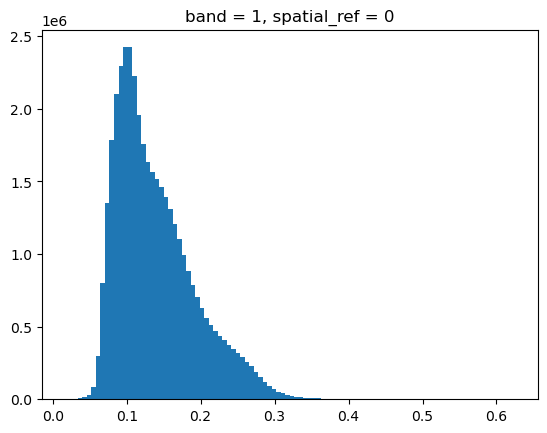

In [70]:
psi_m_200.plot.hist(bins = 100)
plt.show()

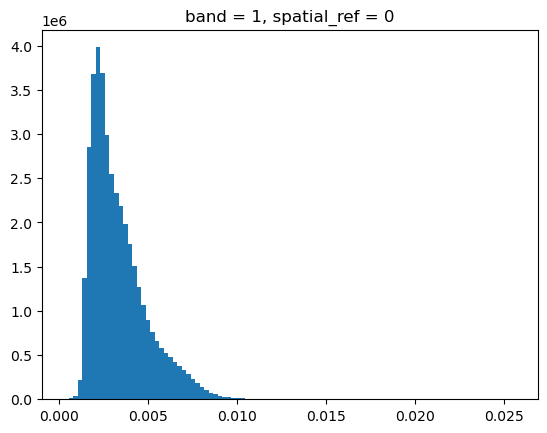

In [71]:
psi_h_2.plot.hist(bins = 100)
plt.show()

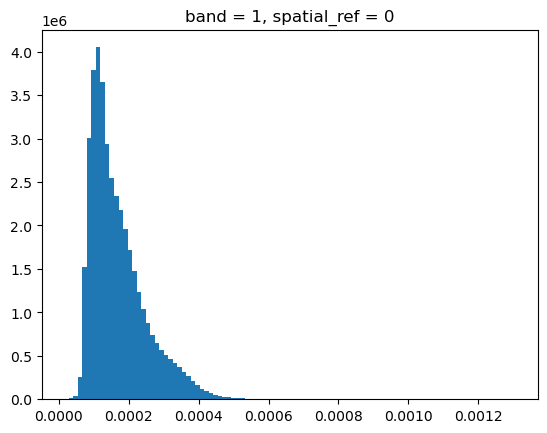

In [72]:
psi_h_01.plot.hist(bins = 100)
plt.show()

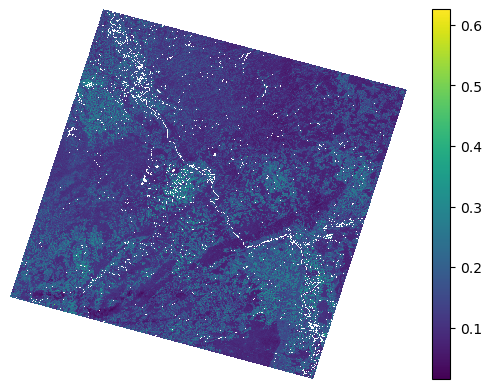

In [73]:
f, ax=plt.subplots()
psi_m_200.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

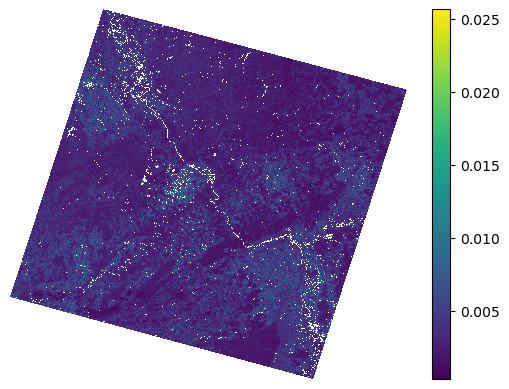

In [74]:
f, ax=plt.subplots()
psi_h_2.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

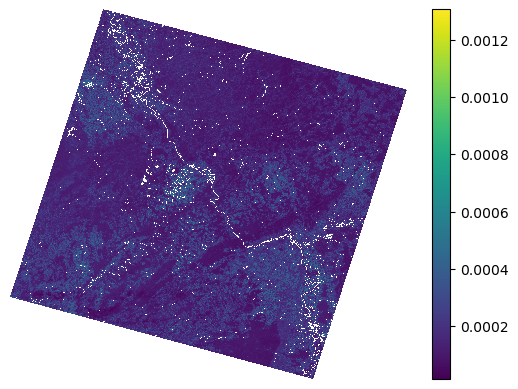

In [75]:
f, ax=plt.subplots()
psi_h_01.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_title("")
plt.show()

c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


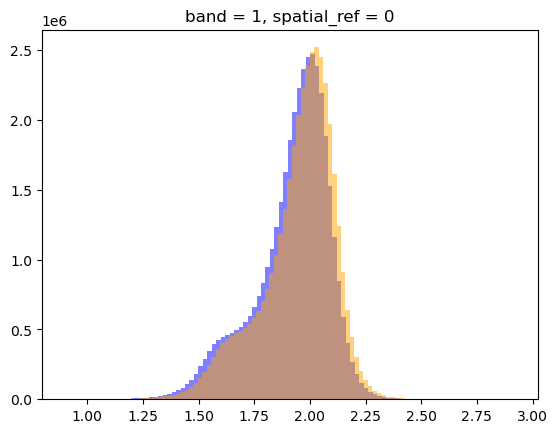

In [76]:
# 9. Calculate corrected Friction Velocity u_asterix_corr
u_asterix_corr = (k*u200) / (np.log(200/zom_px) - psi_m_200)

u_asterix_px.plot.hist(bins = 100, alpha = 0.5, color = "blue")
u_asterix_corr.plot.hist(bins = 100, alpha = 0.5, color = "orange")
plt.show()

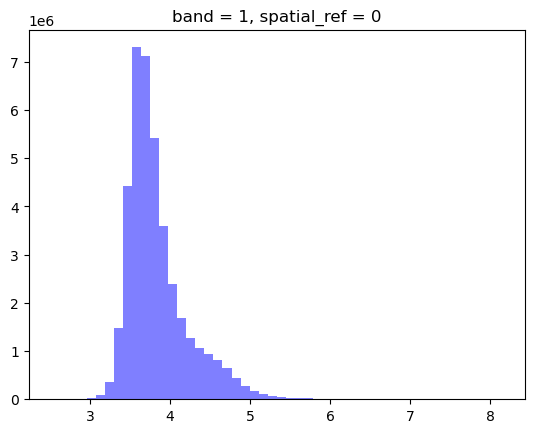

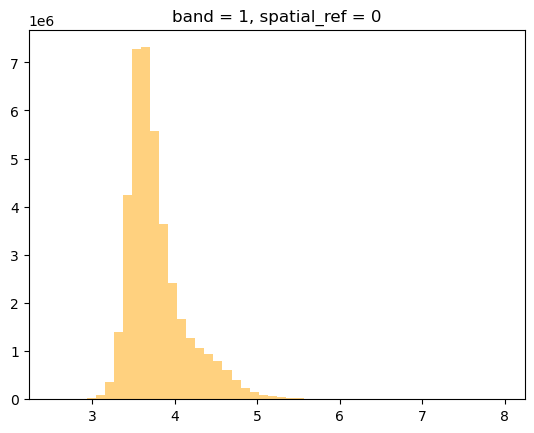

In [77]:
# 10. Corrected Areodynamic Resistance r_ah is calculated

# Initial r_ah:
# z1 = 0.1     # Height 1 for Wind Measurement (m), from SEBAL Manual
# z2 = 2       # Height 2 for Wind Measurement (m), from SEBAL Manual
# r_ah = (np.log(z2/z1)) / (u_asterix_px * k)

# Corrected r_ah_corr
r_ah_corr = (np.log(z2/z1) - psi_h_2 + psi_h_01) / (u_asterix_corr * k)

r_ah.plot.hist(bins = 50, alpha = 0.5, color = "blue")
plt.show()

r_ah_corr.plot.hist(bins = 50, alpha = 0.5, color = "orange")
plt.show()

In [81]:
# 11. Add all steps into for loop
# Outside Loop
# COLD PIXEL
# Test with assumption that Hcold = 0 over water bodie with zero sensible heat flux
H_cold = 0
dT_cold = 0

# HOT PIXEL
H_hot = Rn - G
Ts_nonan = Ts.where(((np.isnan(r_ah) == False)), drop = True)
roh_hot = 1.293     # Air density (kg/m³), Assumed value, should be calculated based on height and T_air
                    # Method after M.L. Fischer: roh_hot = (P *100)/ ((LST - dT) * Rs)
cp = 1004           # Air specific heat (J/kg/K)

# 5.1 Linear Regression on T against dT --> get coeffiients b and a
Ts_cold = Ts_nonan.min()
Ts_hot = Ts_nonan.max()

# Calculate Air density roh 
pressure = 101325  # Air Pressure in Pascal, assumed Value from Wikipedia
Rs_constant = 287.058   # Specific Gas constant in J/Kg*K

g = 9.81    # Gravitational constant, m/s²

# Create Data Frame to save updated values during iteration
cols = ["Iteration", "r_ah_hot", "dT_hot"]
df_stabcorr = pd.DataFrame(columns=cols, index = range(15))


# Inside Loop
for i in range(15):
    # 5. Compute H from dT (near surface temperature difference)
    # Compute H and dT for hot and cold anchor pixels
    
    # Get r_ah for Hot Pixel after filtering r_ah non NAN
    r_ah_hot = r_ah.where(Ts==Ts_nonan.max(), drop = True)
    dT_hot = H_hot * r_ah_hot / (roh_hot*cp)
    
    # 5.1 Linear Regression on T against dT --> get coeffiients b and a
    # Create Arrays for Linear Regression
    Ts_linreg = np.array([Ts_cold.item(), Ts_hot.item()]).reshape((-1, 1))
    dT_linreg = np.array([dT_cold, dT_hot.item()])

    # Build Linear Model
    dT_model = LinearRegression().fit(Ts_linreg, dT_linreg)

    # Extract Coefficients after dT = b + a*Ts
    coeff_b = dT_model.intercept_
    coeff_a = dT_model.coef_ 
    
    # 5.2 Calculate dT for each Pixel based on Ts and and Linear Model dT_model
    dT_pix = coeff_b + coeff_a*Ts_nonan
    
    # 6. Calculate Air Temperature Ta and Air density based on Ts and dT 
    Ta_pix = Ts_nonan - dT_pix

    roh_pix = pressure / (Rs_constant * Ta_pix)

    # 7. Calculate Sensible Heat Flux H with updated r_ah
    H = (roh_pix * cp * dT_pix) / r_ah
    
    # 8. Stability correction/iteration
    # Monin-Obukhov Length L_mo
    L_mo = -(roh_pix * cp * u_asterix_px**3 * Ts) / (k * g * H)
    
    # Filter -inf values
    L_mo_ = L_mo.where(((L_mo < 1000) & (L_mo > -50000)), drop = True)
    
    # Coefficients for Corrections functions below
    x_200 = (1-(16*200/L_mo))**0.25
    x_2 = (1-(16*2/L_mo))**0.25
    x_01 = (1-(16*0.1/L_mo))**0.25

    #####################################
    # Corections for momentum psi_m and heat transport psi_h 
    #####################################
    # 1. Correction for psi_m_200
    #####################################
    # if L_mo < 0
    psi_m_200_neg = (2*np.log((1+x_200)/ 2)) + np.log((1+x_200**2)/2) - 2*np.arctan(x_200) + 0.5*math.pi
    # if L_mo > 0
    psi_m_200_pos = -5*(2/L_mo)

    psi_m_200 = L_mo    
    psi_m_200 = psi_m_200.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_m_200_neg) 
    psi_m_200 = psi_m_200.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_m_200 = psi_m_200.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_m_200_pos) 

    #####################################
    # 2. Correction for psi_h_2
    #####################################
    # if L_mo < 0
    psi_h_2_neg = 2*np.log((1+x_2**2)/2)
    # if L_mo > 0
    psi_h_2_pos = -5*(2/L_mo)

    psi_h_2 = L_mo    
    psi_h_2 = psi_h_2.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_2_neg) 
    psi_h_2 = psi_h_2.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_h_2 = psi_h_2.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_2_pos) 
    
    #####################################
    # 3. Correction for psi_h_01
    #####################################
    # if L_mo < 0
    psi_h_01_neg = 2*np.log((1+x_01**2)/2)
    # if L_mo > 0
    psi_h_01_pos = -5*(0.1/L_mo)

    psi_h_01 = L_mo    
    psi_h_01 = psi_h_01.where(((L_mo > 0) & (np.isnan(L_mo) == False)), psi_h_01_neg) 
    psi_h_01 = psi_h_01.where(((L_mo != 0) & (np.isnan(L_mo) == False)), 0)
    psi_h_01 = psi_h_01.where(((L_mo < 0) & (np.isnan(L_mo) == False)), psi_h_01_pos) 
    
    #####################################
    
    # 9. UPDATE u and r_ah: Calculate corrected Friction Velocity u_asterix_px / 
    u_asterix_px = (k*u200) / (np.log(200/zom_px) - psi_m_200)
    
    # 10. UPDATE u and r_ah: Corrected Areodynamic Resistance r_ah is calculated
    r_ah = (np.log(z2/z1) - psi_h_2 + psi_h_01) / (u_asterix_px * k)
    
    # Save values to Stability Correction DataFrame
    df_stabcorr.loc[i].Iteration = i
    df_stabcorr.loc[i].r_ah_hot = r_ah_hot
    df_stabcorr.loc[i].dT_hot = dT_hot
    


c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
c:\Users\nicol\anaconda3\envs\ET_master_project\Lib\site-packages\xarray\core\computation.py:76

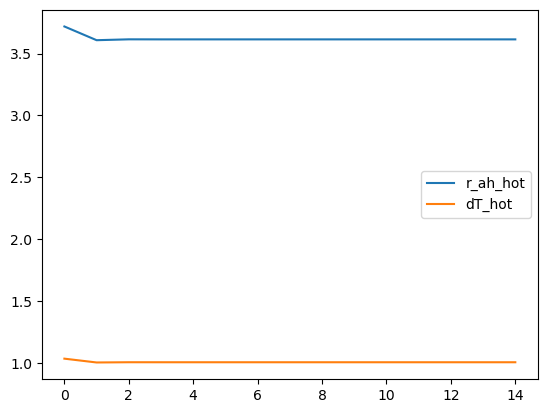

In [131]:
# Plot Change in Stability correction values
plt.plot(df_stabcorr.r_ah_hot, label = df_stabcorr.columns[1])
plt.plot(df_stabcorr.dT_hot, label = df_stabcorr.columns[2])
plt.legend()
plt.show()

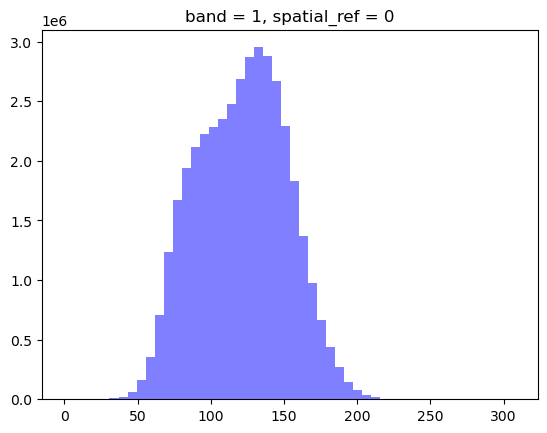

In [132]:
H.plot.hist(bins = 50, alpha = 0.5, color = "blue")
plt.show()

### 3.3 ET - Latent Heat Flux

In [133]:
# Quick and Dirty Calculation of ET (to this point without iterative correction)
ETL = Rn - G_filt - H
ETL = ETL.where(ETL>=0)


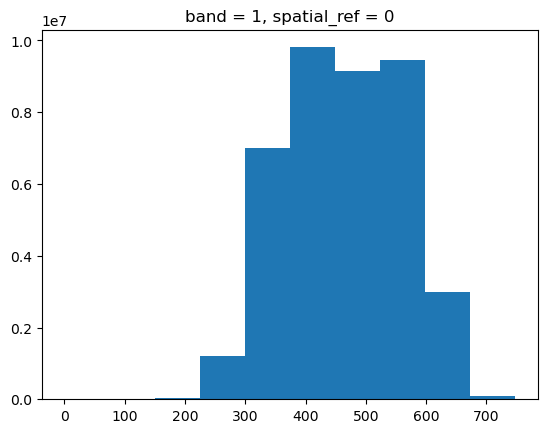

In [134]:
ETL.plot.hist()
plt.show()

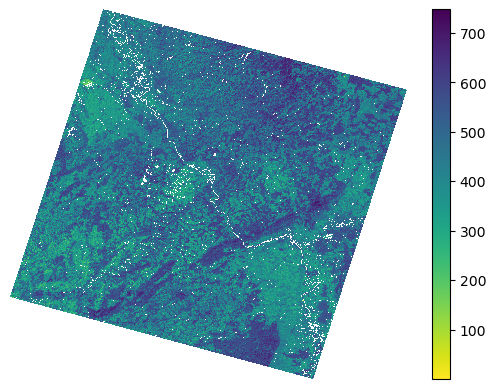

In [135]:
# Plot the data
f, ax=plt.subplots()
ETL.plot.imshow(ax=ax,
               cmap = "viridis_r")
ax.set_axis_off()
ax.set_title("")
plt.show()

(array([4.510000e+02, 2.998000e+03, 4.143200e+04, 1.212377e+06,
        7.015240e+06, 9.808131e+06, 9.148622e+06, 9.461906e+06,
        2.999968e+06, 1.030790e+05]),
 array([3.77664325e-04, 1.19994053e-01, 2.39610441e-01, 3.59226829e-01,
        4.78843217e-01, 5.98459606e-01, 7.18075994e-01, 8.37692382e-01,
        9.57308770e-01, 1.07692516e+00, 1.19654155e+00]),
 <BarContainer object of 10 artists>)

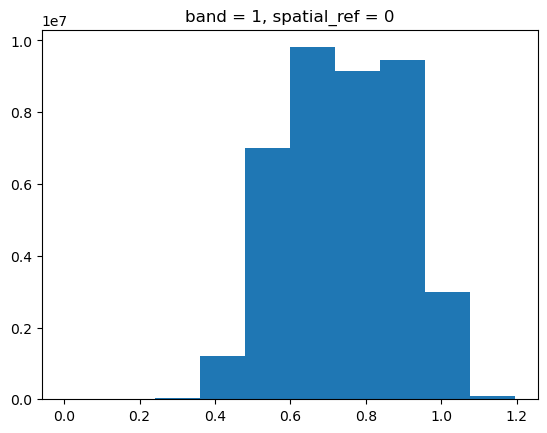

In [136]:
# From ET_lambda to ET in mm/hour
lamda = 2.25 * 10**6 # Latet heat of Vaporization J/kg
ET_inst = 3600* (ETL / lamda)

ET_inst.plot.hist()

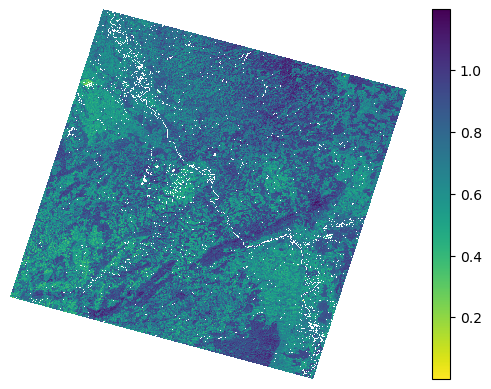

In [137]:
# Plot the data
f, ax=plt.subplots()
ET_inst.plot.imshow(ax=ax,
               cmap = "viridis_r")
ax.set_axis_off()
ax.set_title("")
plt.show()